# by filename

In [1]:
import os
import json
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from collections import defaultdict

# Create an empty list to store DataFrames
dataframes = []
index = 0
file_counter = Counter()  # Counter to store counts of each filename
data_path = '../../../datasets/geolife_files/Data/'

duplicate_files = defaultdict(list)
file_count = {}

# Traverse through user directories
for user_folder in tqdm(os.listdir(data_path)):
    user_folder_path = os.path.join(data_path, user_folder)
    user_id = os.path.basename(user_folder_path)

    # Check if it's a directory
    if os.path.isdir(user_folder_path):
        trajectory_dir = os.path.join(user_folder_path, 'Trajectory')

        # Check if 'Trajectory' directory exists
        if os.path.exists(trajectory_dir) and os.path.isdir(trajectory_dir):
            # Loop through trajectory files for each user
            
            for trajectory_file in os.listdir(trajectory_dir):
                if trajectory_file.endswith('.plt'):
                    # trajectory_file_path = os.path.join(trajectory_dir, trajectory_file)
                    # Extract file name
                    file_name = trajectory_file
                    if user_id in file_count.keys():
                        file_count[user_id]+=1
                    else:
                        file_count[user_id]=1
                    
                    # Check if the file name is already encountered
                    if file_name in duplicate_files:
                        duplicate_files[file_name].append(user_id)
                    else:
                        duplicate_files[file_name] = [user_id]



100%|███████████████████████████████████████| 182/182 [00:00<00:00, 5391.14it/s]


In [2]:
total_files = []
for k in file_count.keys():
    total_files.append([k, file_count[k]])
total_files = pd.DataFrame(total_files, columns=['user','total_count'])
total_files

,user,total_count
0,057,22
1,104,115
2,058,22
3,125,57
4,021,8
...,...,...
177,009,49
178,093,23
179,175,4
180,111,44


In [3]:
import pandas as pd
import json

data = []
count = 0

for file_name, folders in duplicate_files.items():
    if len(folders) > 1:
        count += 1
        
        for i in range(len(folders)):
            data.append({'file_name': file_name, 'user': folders[i], 'duplicates': json.dumps(folders), "num": len(folders)})

df = pd.DataFrame(data)

# if not (os.path.isdir('./files/')):
# 		os.makedirs('./files/')
# df.to_csv('./files/duplicate_files.csv', index=False)

print("Found", count, "duplicates.")


Found 847 duplicates.


In [4]:
df.to_csv('data/geolife_duplicates_names.csv', index=False)

In [5]:
df.groupby('user').size().sort_values(ascending=False)
grouped_df = df.groupby('user').size().reset_index(name='Count')

# Sorting by 'Count' column if needed
grouped_df = grouped_df.sort_values(by='Count', ascending=False).reset_index(drop=True)
grouped_df

,user,Count
0,153,284
1,163,240
2,167,158
3,126,157
4,003,131
...,...,...
58,030,1
59,005,1
60,062,1
61,169,1


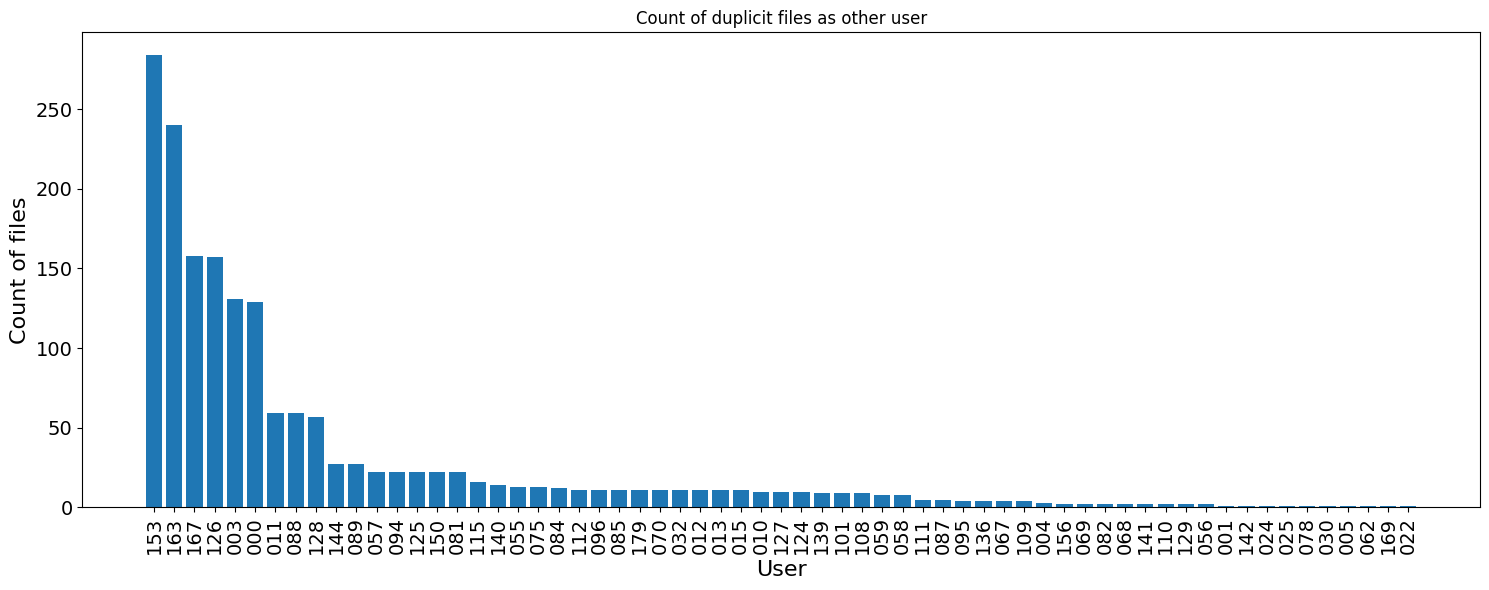

In [6]:
plt.figure(figsize=(15, 6))
plt.bar(grouped_df['user'], grouped_df['Count'])
plt.xlabel('User', fontsize=16)
plt.ylabel('Count of files', fontsize=16)
plt.title('Count of duplicit files as other user')
plt.xticks(fontsize=14, rotation=90)  # Change font size for x-axis tick labels
plt.yticks(fontsize=14)  # Change font size for y-axis tick labels
plt.tight_layout()
plt.savefig("images/geolife_duplicit_file.png") 
plt.show()

In [7]:
duplicates_with_total = pd.merge(grouped_df, total_files, on='user', how='inner')

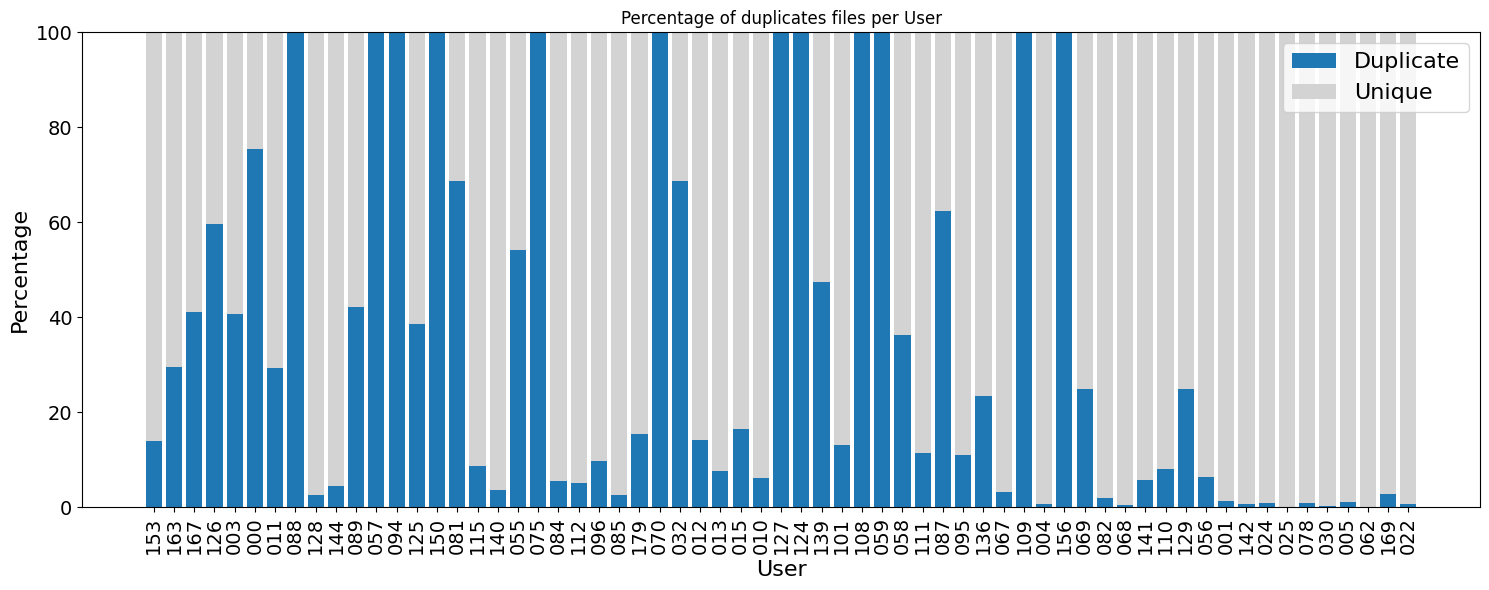

In [8]:
duplicates_with_total['c'] = (duplicates_with_total['Count'] / duplicates_with_total['total_count']) * 100
duplicates_with_total['u'] = 100 - duplicates_with_total['c']

# Step 5: Plotting
plt.figure(figsize=(15, 6))
plt.bar(duplicates_with_total['user'], duplicates_with_total['c'], label='Duplicate')
plt.bar(duplicates_with_total['user'], duplicates_with_total['u'], bottom=duplicates_with_total['c'], label='Unique', color='lightgray')

plt.xlabel('User', fontsize=16)
plt.ylabel('Percentage', fontsize=16)
plt.xticks(fontsize=14)  # Change font size for x-axis tick labels
plt.yticks(fontsize=14)  # Change font size for y-axis tick labels
plt.legend(fontsize=16)  # Change font size for legend
plt.title('Percentage of duplicates files per User')
# plt.legend()
plt.xticks(rotation=90)  # Rotate labels to make them readable
plt.tight_layout()
plt.savefig("images/geolife_duplicit_file_names_percentage.png") 
plt.show()

In [9]:
duplicates_with_total[duplicates_with_total['total_count']-duplicates_with_total['Count']==0]

,user,Count,total_count,c,u
7,088,59,59,100.0,0.0
11,057,22,22,100.0,0.0
12,094,22,22,100.0,0.0
14,150,22,22,100.0,0.0
19,075,13,13,100.0,0.0
25,070,11,11,100.0,0.0
31,127,10,10,100.0,0.0
32,124,10,10,100.0,0.0
35,108,9,9,100.0,0.0
36,059,8,8,100.0,0.0


# by content

In [10]:
def files_are_equal(file_path1, file_path2):
    with open(file_path1, 'r') as file1, open(file_path2, 'r') as file2:
        file1_content = file1.read()
        file2_content = file2.read()
        return file1_content == file2_content

In [11]:
thesame = []
for i in range(len(df)):
    x = df.iloc[i]
    f1 = data_path +  x['user'] + "/Trajectory/"+x['file_name']
    duplicates = []
    for j in json.loads(x['duplicates']):
        if x['user']==j:
            continue
        f2 = data_path + j + "/Trajectory/"+x['file_name']
        if files_are_equal(f1,f2):
            duplicates.append(j)
    if len(duplicates)>0:
        thesame.append([x['file_name'], x['user'] , json.dumps(duplicates), len(duplicates)])
thesame = pd.DataFrame(thesame, columns=df.columns)
thesame.to_csv('data/geolife_duplicates_content.csv', index=False)
thesame

,file_name,user,duplicates,num
0,20070805013330.plt,057,"[""094"", ""150""]",2
1,20070805013330.plt,094,"[""057"", ""150""]",2
2,20070805013330.plt,150,"[""057"", ""094""]",2
3,20070801111718.plt,057,"[""094"", ""150""]",2
4,20070801111718.plt,094,"[""057"", ""150""]",2
...,...,...,...,...
1672,20080629121541.plt,101,"[""126""]",1
1673,20080629025234.plt,126,"[""101""]",1
1674,20080629025234.plt,101,"[""126""]",1
1675,20080630071610.plt,126,"[""101""]",1


In [12]:
grouped_same = thesame.groupby('user').size().reset_index(name='Count')

# Sorting by 'Count' column if needed
grouped_same = grouped_same.sort_values(by='Count', ascending=False).reset_index(drop=True)
grouped_same

,user,Count
0,153,278
1,163,235
2,126,150
3,167,149
4,000,129
5,003,129
6,088,59
7,011,59
8,128,55
9,144,25


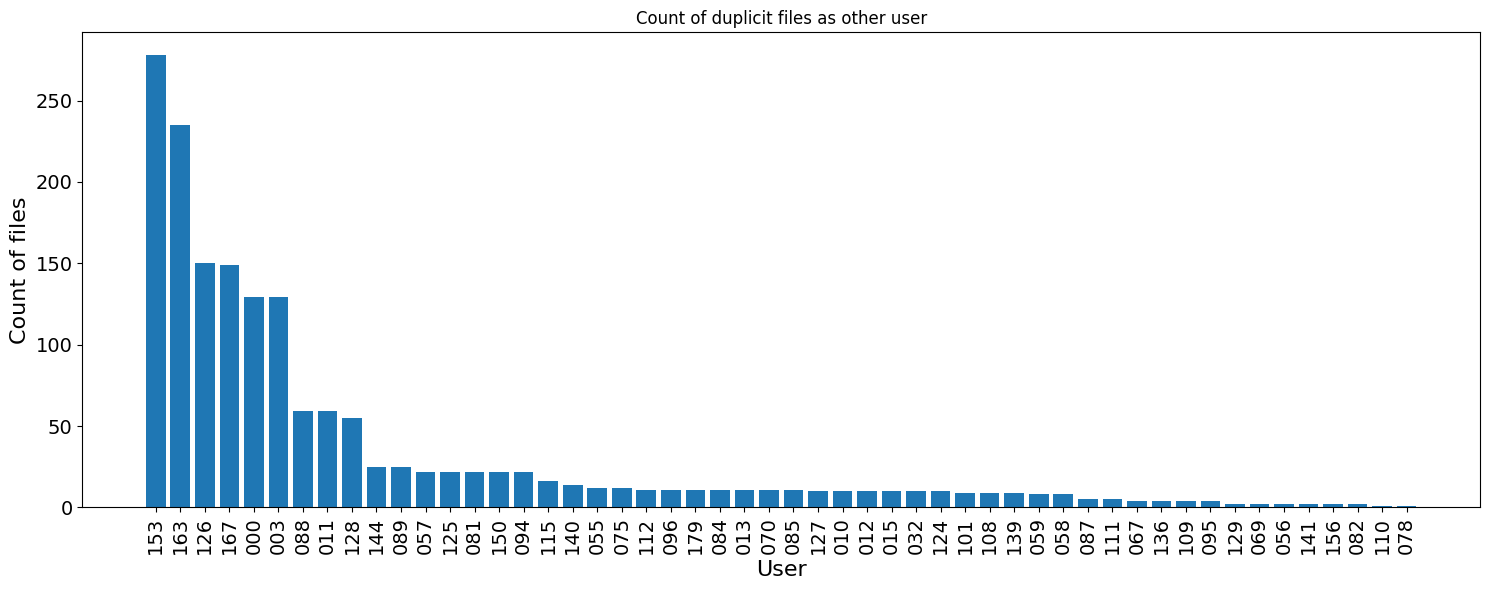

In [13]:
plt.figure(figsize=(15, 6))
plt.bar(grouped_same['user'], grouped_same['Count'])
plt.xlabel('User', fontsize=16)
plt.ylabel('Count of files', fontsize=16)
plt.title('Count of duplicit files as other user')
plt.xticks(fontsize=14, rotation=90)  # Change font size for x-axis tick labels
plt.yticks(fontsize=14)  # Change font size for y-axis tick labels
plt.tight_layout()
plt.savefig("images/geolife_duplicit_file.png") 
plt.show()

In [14]:
same_duplicates_with_total = pd.merge(grouped_same, total_files, on='user', how='inner')

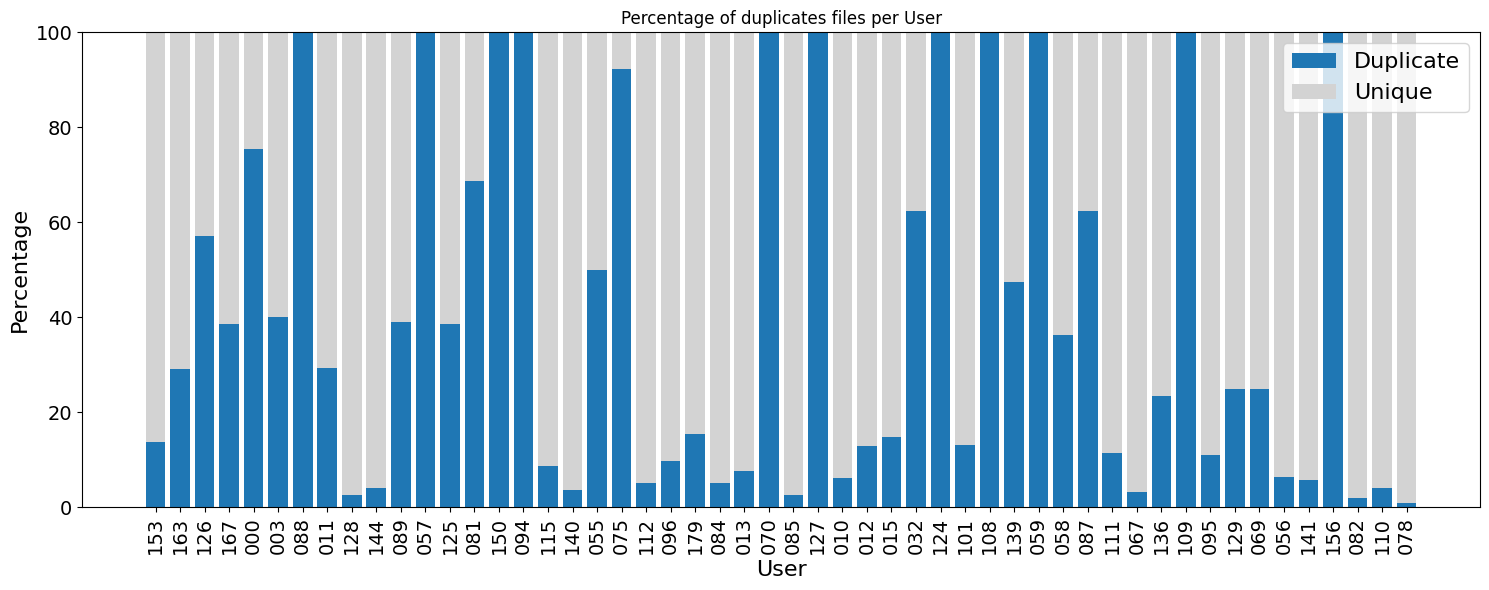

In [15]:
same_duplicates_with_total['c'] = (same_duplicates_with_total['Count'] / same_duplicates_with_total['total_count']) * 100
same_duplicates_with_total['u'] = 100 - same_duplicates_with_total['c']

# Step 5: Plotting
plt.figure(figsize=(15, 6))
plt.bar(same_duplicates_with_total['user'], same_duplicates_with_total['c'], label='Duplicate')
plt.bar(same_duplicates_with_total['user'], same_duplicates_with_total['u'], bottom=same_duplicates_with_total['c'], label='Unique', color='lightgray')

plt.xlabel('User', fontsize=16)
plt.ylabel('Percentage', fontsize=16)
plt.xticks(fontsize=14)  # Change font size for x-axis tick labels
plt.yticks(fontsize=14)  # Change font size for y-axis tick labels
plt.legend(fontsize=16)  # Change font size for legend
plt.title('Percentage of duplicates files per User')
# plt.legend()
plt.xticks(rotation=90)  # Rotate labels to make them readable
plt.tight_layout()
plt.savefig("images/geolife_duplicit_files_percentage.png") 
plt.show()

In [16]:
duplicates_with_total[duplicates_with_total['total_count']-duplicates_with_total['Count']==0]

,user,Count,total_count,c,u
7,088,59,59,100.0,0.0
11,057,22,22,100.0,0.0
12,094,22,22,100.0,0.0
14,150,22,22,100.0,0.0
19,075,13,13,100.0,0.0
25,070,11,11,100.0,0.0
31,127,10,10,100.0,0.0
32,124,10,10,100.0,0.0
35,108,9,9,100.0,0.0
36,059,8,8,100.0,0.0
